In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse


In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Tenerife = datos[datos['isla'] == 'TENERIFE']

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_Tenerife_mult_atm = datos_Tenerife[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_Tenerife_mult_total = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0417 - val_loss: 0.0234
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0340 - val_loss: 0.0216
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0344 - val_loss: 0.0214
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0331 - val_loss: 0.0184
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0284 - val_loss: 0.0176
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0234 - val_loss: 0.0163
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - val_loss: 0.0151
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0227 - val_loss: 0.0136
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.01

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


In [11]:
y_pred

array([[869.77893],
       [827.4005 ],
       [787.84357],
       [731.5493 ],
       [766.5263 ],
       [822.7509 ],
       [736.3098 ],
       [642.71234],
       [593.3132 ],
       [578.9522 ]], dtype=float32)

In [12]:
y_test

array([[269.],
       [193.],
       [636.],
       [760.],
       [716.],
       [607.],
       [636.],
       [266.],
       [163.],
       [319.]])

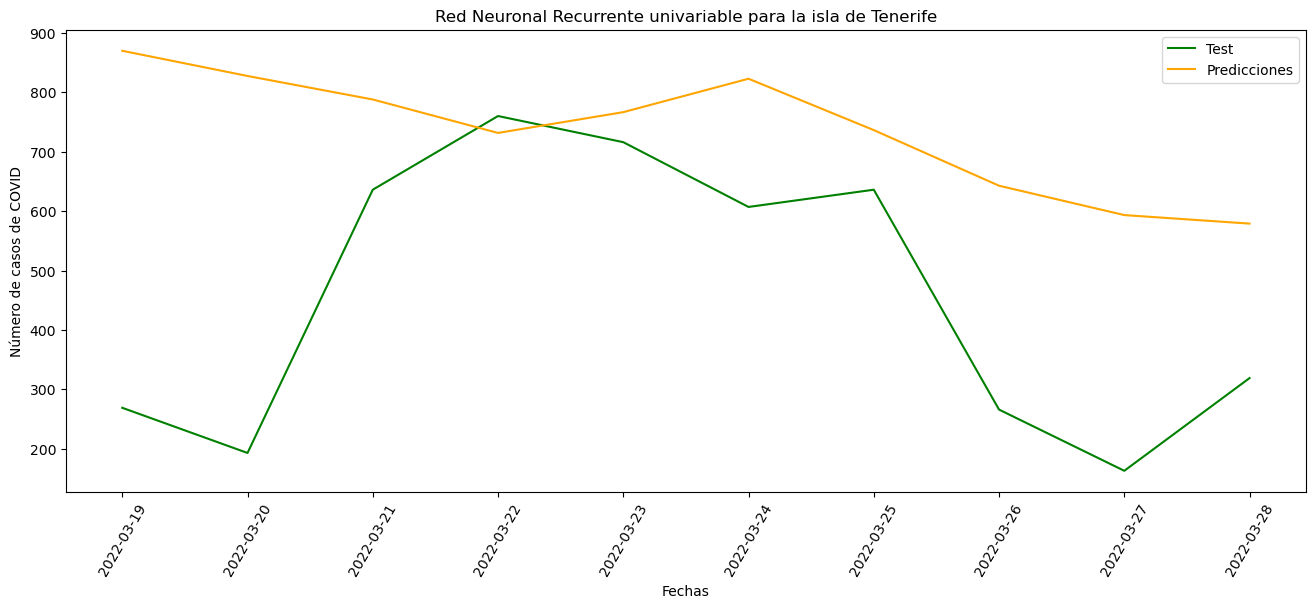

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

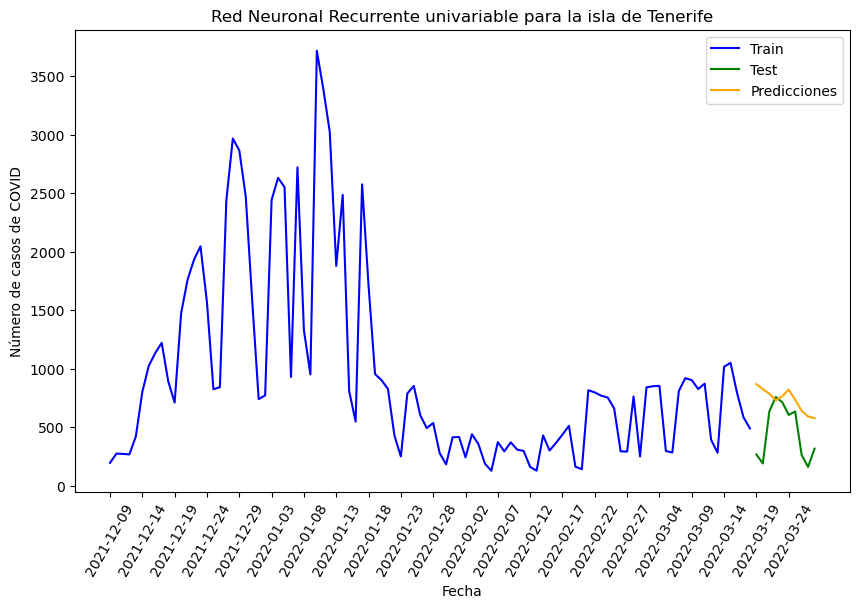

In [14]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [15]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 124108.5433054857
Error absoluto medio (MAE) del modelo: 284.9038452148437
Raíz del error cuadrático medio (RMSE) del modelo: 352.290424657676


# Red Neuronal Recurrente multivariable con variables de pandemia

In [16]:
datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)

In [17]:
# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0466 - val_loss: 0.0260
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0372 - val_loss: 0.0232
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0341 - val_loss: 0.0199
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - val_loss: 0.0180
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0245 - val_loss: 0.0170
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0254 - val_loss: 0.0180
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0196 - val_loss: 0.0150
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0187 - val_loss: 0.0140
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0212 - val_loss: 0.0129
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - val_loss: 0.0133
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0185 - val_loss: 0.0113
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

In [21]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


In [22]:
y_pred

array([[696.316  ],
       [674.81824],
       [666.98846],
       [627.80396],
       [619.40375],
       [656.80725],
       [621.2282 ],
       [574.80145],
       [565.7115 ],
       [601.3546 ]], dtype=float32)

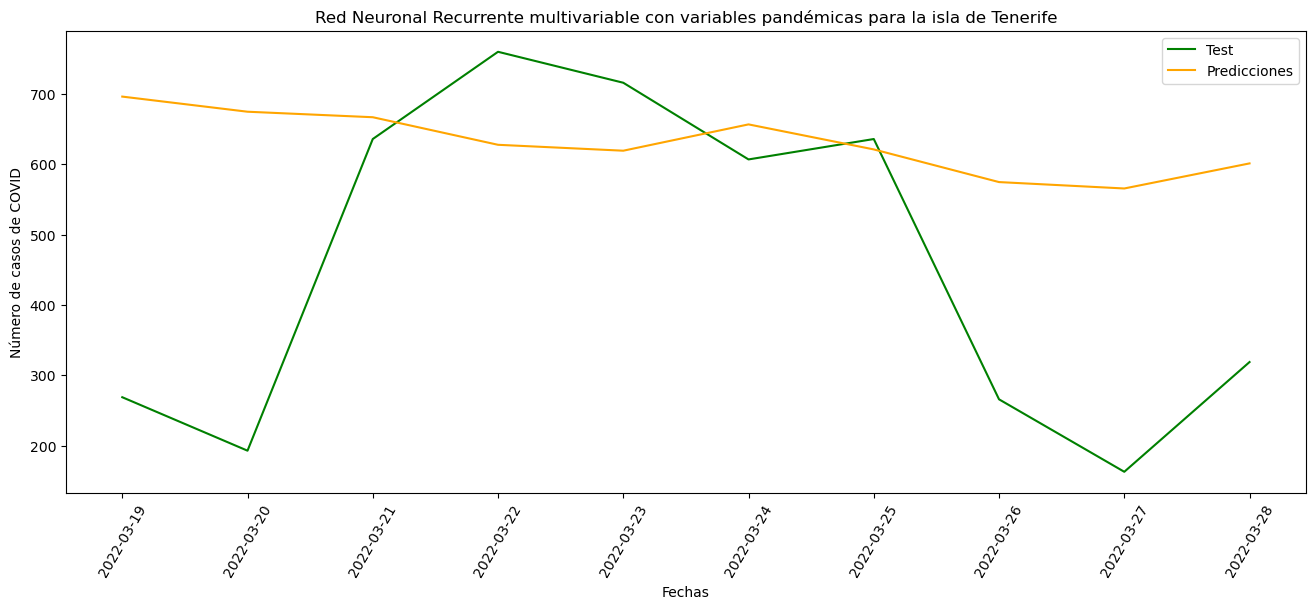

In [23]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

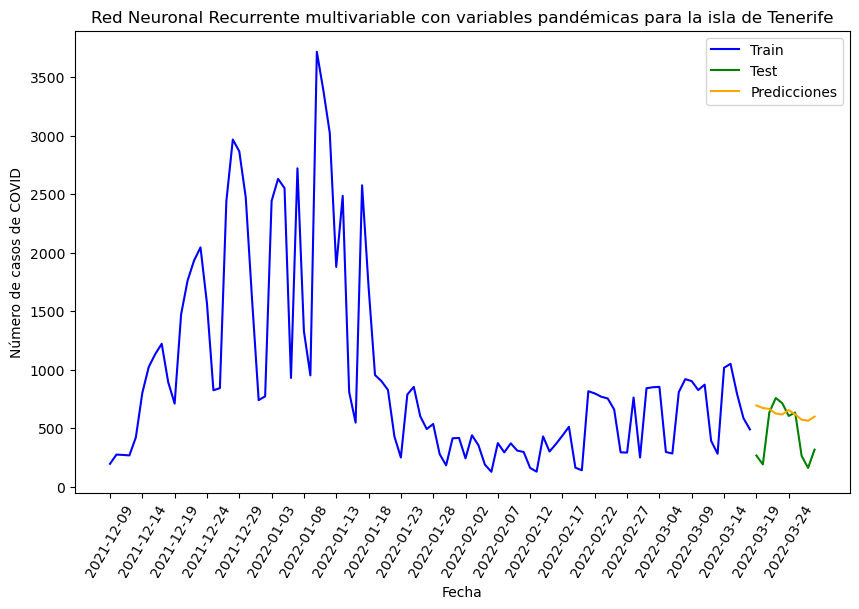

In [24]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [25]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 78247.26498867646
Error absoluto medio (MAE) del modelo: 222.7361572265625
Raíz del error cuadrático medio (RMSE) del modelo: 279.7271259436175


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [27]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [28]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0477 - val_loss: 0.0286
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0487 - val_loss: 0.0261
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0409 - val_loss: 0.0239
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0351 - val_loss: 0.0218
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0335 - val_loss: 0.0206
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0296 - val_loss: 0.0214
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0281 - val_loss: 0.0172
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0242 - val_loss: 0.0170
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0220 - val_loss: 0.0158
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0225 - val_loss: 0.0162
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0201 - val_loss: 0.0450
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

In [30]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


In [31]:
y_pred

array([[894.1241 ],
       [847.0154 ],
       [794.1615 ],
       [760.5179 ],
       [754.04126],
       [743.6561 ],
       [724.2293 ],
       [712.4753 ],
       [680.89215],
       [668.91364]], dtype=float32)

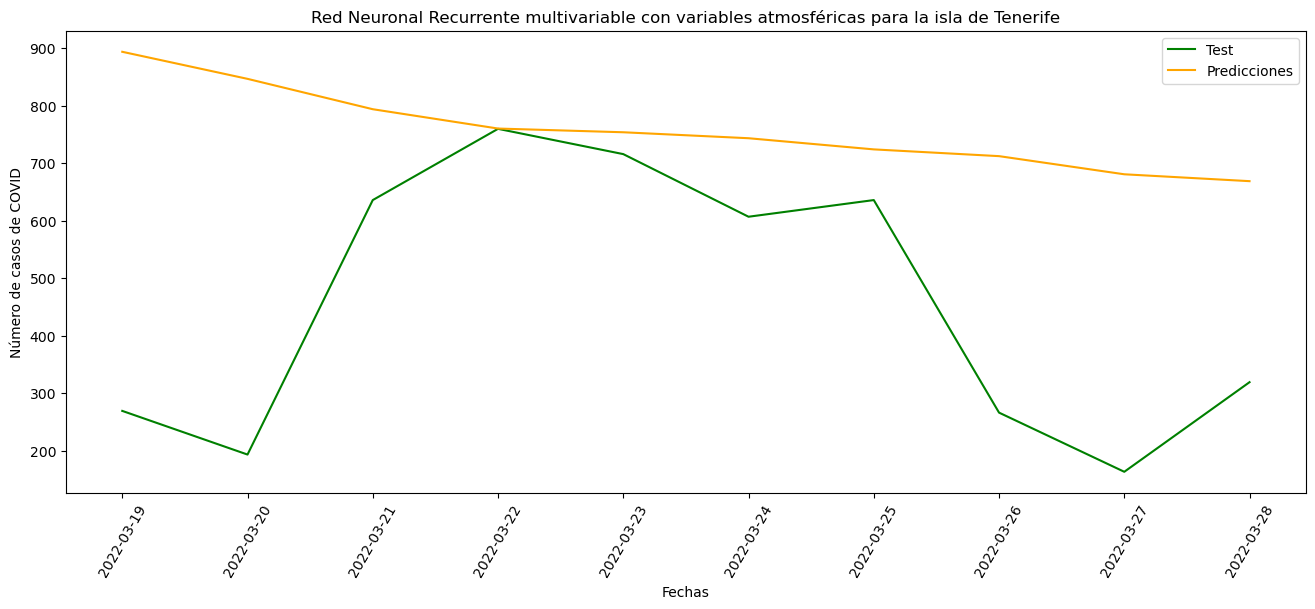

In [32]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

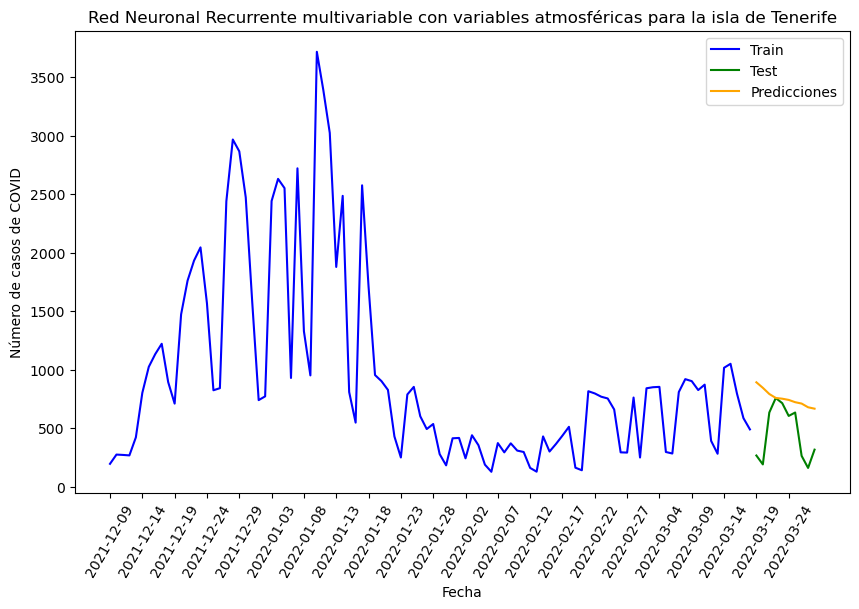

In [33]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [34]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 146143.00215010866
Error absoluto medio (MAE) del modelo: 301.5026611328125
Raíz del error cuadrático medio (RMSE) del modelo: 382.28654455801694


# Red Neuronal Recurrente multivariable con todas las variables

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [36]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [37]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0319 - val_loss: 0.0212
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - val_loss: 0.0260
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0291 - val_loss: 0.0193
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0239 - val_loss: 0.0184
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0222 - val_loss: 0.0226
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0192 - val_loss: 0.0180
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0170 - val_loss: 0.0194
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0225 - val_loss: 0.0136
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0121
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0

In [39]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


In [40]:
y_pred

array([[785.39   ],
       [760.2632 ],
       [738.0443 ],
       [685.93054],
       [721.8996 ],
       [743.7523 ],
       [688.6255 ],
       [639.63495],
       [606.3874 ],
       [605.11945]], dtype=float32)

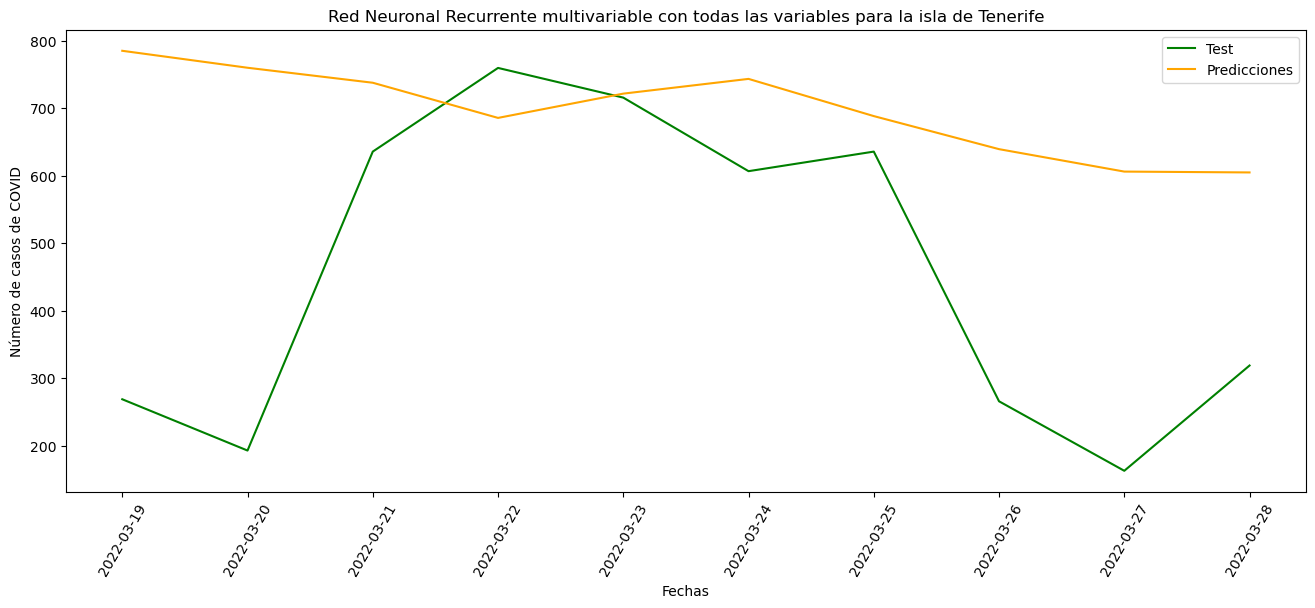

In [41]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

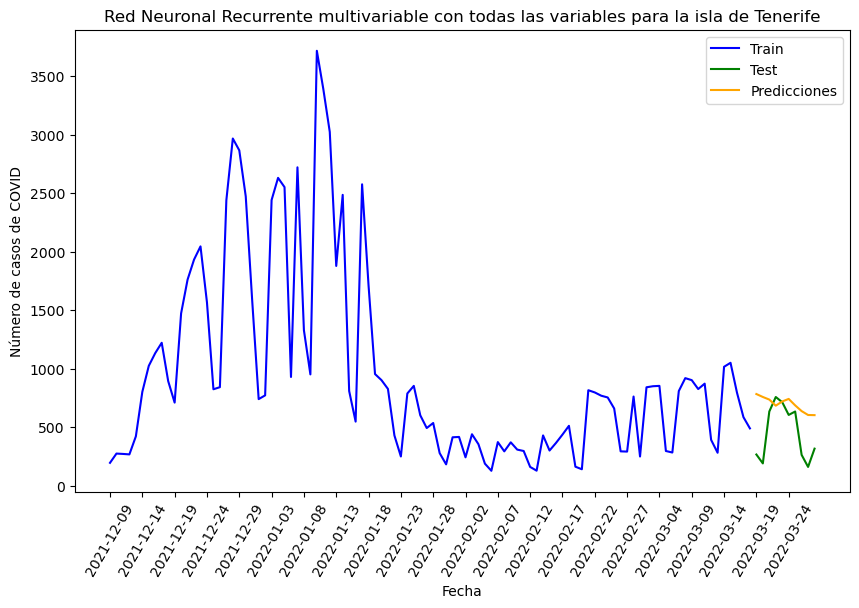

In [42]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [43]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 104391.0726831153
Error absoluto medio (MAE) del modelo: 255.81861572265626
Raíz del error cuadrático medio (RMSE) del modelo: 323.096073456666
